# S2 parametrization

In [2]:
import os
import shutil
import collections

import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt

import invisible_cities.core.fit_functions as fitf

In [3]:
profile = collections.namedtuple("profile", "x y u")

In [4]:
%matplotlib inline

plt.rcParams["figure.figsize"] = 12, 8
plt.rcParams[  "font.size"   ] = 15

In [8]:
path_tables       = "/Volumes/SAMSUNG/NEXT100tables/S2"
filename_cathode  = os.path.join(path_tables,       "Cathode.dat")
filename_anode    = os.path.join(path_tables,         "Anode.dat")
filename_pmt_map  = os.path.join(path_tables,   "pmt_mapping.dat")
filename_sipm_map = os.path.join(path_tables,  "sipm_mapping.dat")
filename_el_map   = os.path.join(path_tables,    "el_mapping.dat")

In [9]:
def load_df_cathode(filename, df_el, df_pmt):
    new_columns        = ["PointID", "SensorID", "Ring", "X", "Y", "R", "Phi", "Sum"] + [f"P{i}" for i in range(20)]
    df_cathode         = pd.DataFrame.from_csv(filename, sep=" ", index_col=None)
    df_cathode["Sum"]  = df_cathode.values[:, 3:].sum(axis=1)
    df_cathode["X"  ]  = df_cathode.PointID.map(df_el.X)
    df_cathode["Y"  ]  = df_cathode.PointID.map(df_el.Y)
    df_cathode["R"  ]  = np.sqrt   (df_cathode.X**2 + df_cathode.Y**2)
    df_cathode["Phi"]  = np.arctan2(df_cathode.Y, df_cathode.X)
    df_cathode["Ring"] = df_cathode.SensorID.map(df_pmt.Corona)
    df_cathode         = df_cathode.reindex(columns = new_columns)
    df_cathode.sort_values("SensorID")
    return df_cathode

def load_df_anode(filename, df_el, df_sipm, r_max):
    new_columns     = ["PointID", "SensorID", "dX", "dY", "dR", "R"] + [f"P{i}" for i in range(2)]
    df_anode        = pd.DataFrame.from_csv(filename, sep=" ", index_col=None)
    x_el            = df_anode.PointID .map(df_el.X)
    y_el            = df_anode.PointID .map(df_el.Y)
    x_sipm          = df_anode.SensorID.map(df_sipm.X)
    y_sipm          = df_anode.SensorID.map(df_sipm.Y)
    df_anode["dX" ] = x_sipm - x_el
    df_anode["dY" ] = y_sipm - y_el
    df_anode["dR" ] = np.sqrt(df_anode.dX**2 + df_anode.dY**2)
    df_anode[ "R" ] = np.sqrt(       x_el**2 +        y_el**2)
    df_anode        = df_anode[df_anode.dR <= r_max]
    df_anode        = df_anode.reindex(columns = new_columns)
    df_anode.sort_values("SensorID")
    return df_anode

@np.vectorize
def to_index(sensor_id):
    return (sensor_id // 1000 - 1) * 64   + sensor_id % 1000

In [10]:
pmt         = pd.DataFrame.from_csv(filename_pmt_map , sep=" ", index_col=0)
sipm        = pd.DataFrame.from_csv(filename_sipm_map, sep=" ", index_col=0)
el          = pd.DataFrame.from_csv(filename_el_map  , sep=" ", index_col=0)
sipm["idx"] = to_index(sipm.index)

In [ ]:
df_cathode = load_df_cathode(filename_cathode, el, pmt)
df_anode   = load_df_anode  (filename_anode  , el, sipm, r_max=20)

In [8]:
df_cathode.head()

,PointID,SensorID,Ring,X,Y,R,Phi,Sum,P0,P1,...,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19
0,1060,0,0,-186.0,-29.0,188.247178,-2.986924,0.000437,0.000020,0.000022,...,0.000022,0.000020,0.000022,0.000022,0.000022,0.000025,0.000022,0.000022,0.000023,0.000020
1,1060,1,0,-186.0,-29.0,188.247178,-2.986924,0.000437,0.000019,0.000022,...,0.000023,0.000022,0.000022,0.000022,0.000023,0.000022,0.000021,0.000022,0.000023,0.000022
2,1060,2,0,-186.0,-29.0,188.247178,-2.986924,0.000429,0.000021,0.000024,...,0.000022,0.000022,0.000020,0.000023,0.000021,0.000021,0.000023,0.000021,0.000019,0.000023
3,1060,3,1,-186.0,-29.0,188.247178,-2.986924,0.000318,0.000014,0.000017,...,0.000016,0.000014,0.000017,0.000014,0.000016,0.000015,0.000016,0.000016,0.000016,0.000014
4,1060,4,1,-186.0,-29.0,188.247178,-2.986924,0.000329,0.000014,0.000014,...,0.000019,0.000017,0.000017,0.000016,0.000018,0.000017,0.000016,0.000016,0.000014,0.000016


In [9]:
df_anode.head()

,PointID,SensorID,dX,dY,dR,R,P0,P1
135,1060,27008,11.0,-6.0,12.529964,188.247178,0.000014,0.000014
136,1060,27009,11.0,4.0,11.704700,188.247178,0.000017,0.000015
137,1060,27010,11.0,14.0,17.804494,188.247178,0.000008,0.000005
143,1060,27016,1.0,-6.0,6.082763,188.247178,0.000057,0.000056
144,1060,27017,1.0,4.0,4.123106,188.247178,0.000092,0.000123


# Control plots

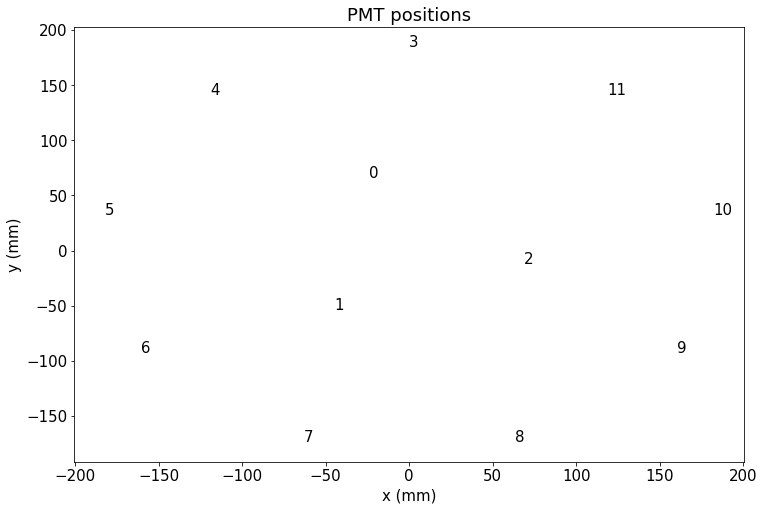

In [10]:
plt.scatter(pmt.X, pmt.Y, s=0)
for pmt_no, row in pmt.iterrows():
    plt.text(row.X, row.Y, str(int(pmt_no)))
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.title ("PMT positions");

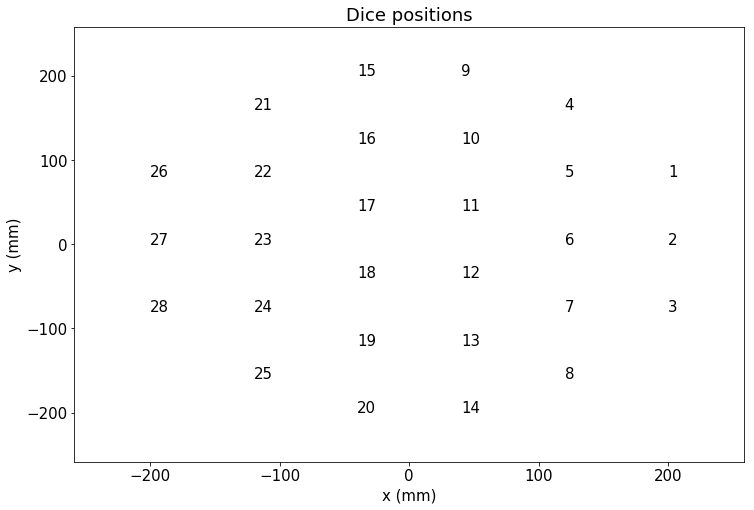

In [11]:
plt.scatter(sipm.X, sipm.Y, s=0)
for dice_no, dice in sipm.groupby("Dice"):
    x = dice.X.mean()
    y = dice.Y.mean()
    plt.text(x, y, str(int(dice_no)))
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.title ("Dice positions");

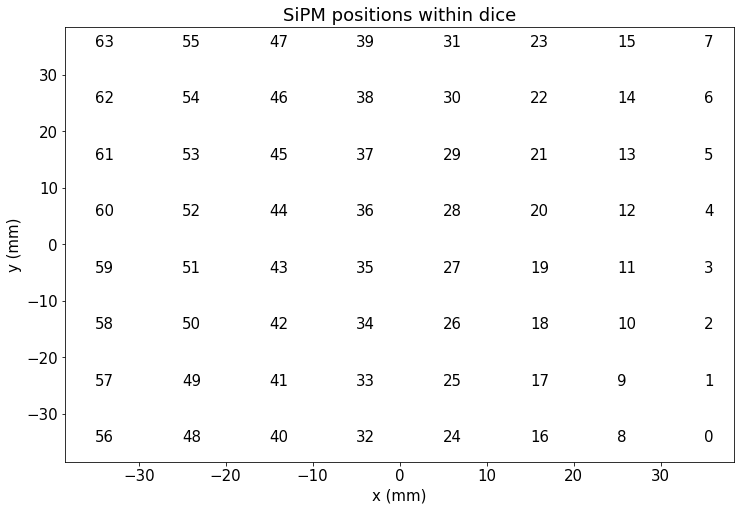

In [12]:
for dice_no, dice in sipm.groupby("Dice"):
    xmean = dice.X.mean()
    ymean = dice.Y.mean()
    plt.scatter(dice.X - xmean, dice.Y - ymean, s=0)
    for sipm_no, row in dice.iterrows():
        plt.text(row.X - xmean, row.Y - ymean, str(int(sipm_no - 1000 * dice_no)))
    break
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.title ("SiPM positions within dice");

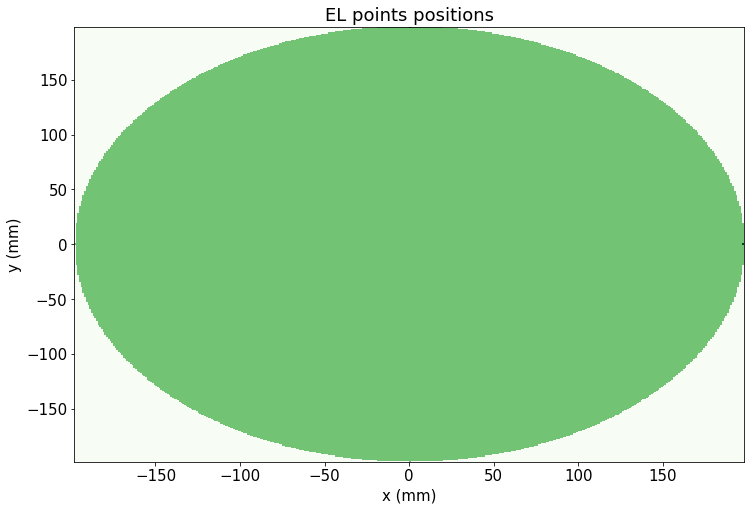

In [13]:
x_binning = np.arange(np.min(el.X), np.max(el.X) + 1)
y_binning = np.arange(np.min(el.Y), np.max(el.Y) + 1)
plt.hist2d(el.X, el.Y, (x_binning, y_binning), cmap="Greens")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.title ("EL points positions");

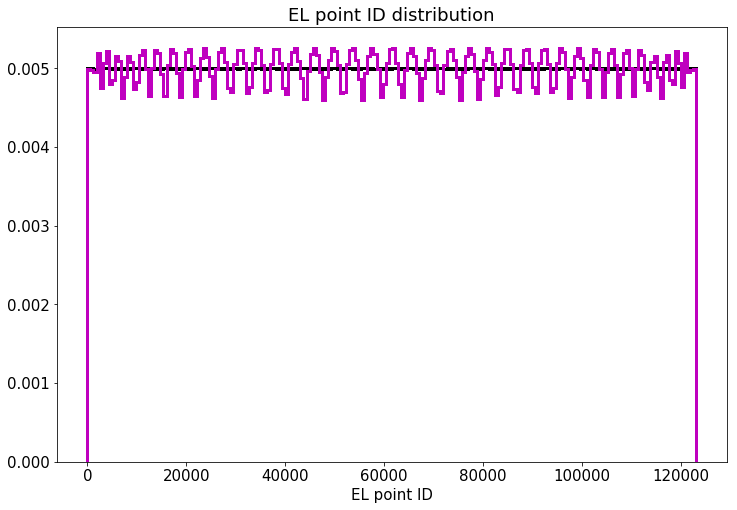

In [14]:
bins = np.linspace(el.index.min(), el.index.max(), 201)

weights = np.ones(len(el)) / len(el)
plt.hist(el.index, bins=bins, weights=weights, color="k", histtype="step", lw=3)

weights = np.ones(len(df_anode)) / len(df_anode)
plt.hist(df_anode.PointID, bins=bins, weights=weights, color="m", histtype="step", lw=3)

plt.xlabel("EL point ID")
plt.ylabel("")
plt.title ("EL point ID distribution");

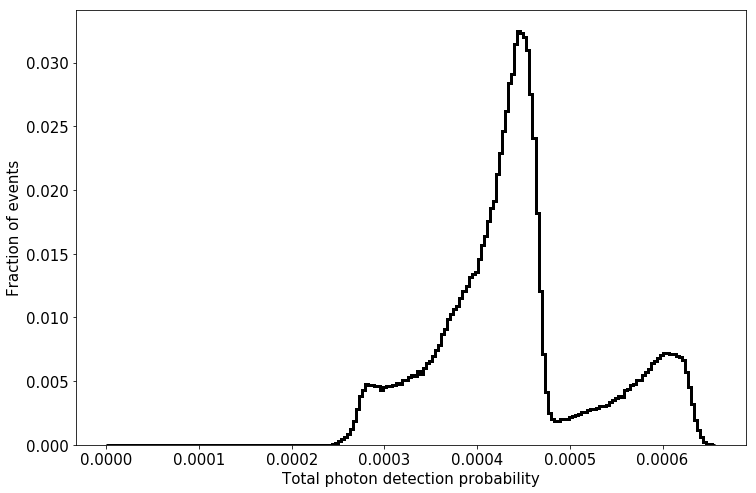

In [15]:
bins    = np.linspace(0, np.max(df_cathode.Sum), 201)
weights = np.ones(len(df_cathode)) / len(df_cathode)
plt.hist(df_cathode.Sum, bins = bins, weights = weights, color="k", histtype="step", lw=3)
plt.xlabel("Total photon detection probability")
plt.ylabel("Fraction of events")

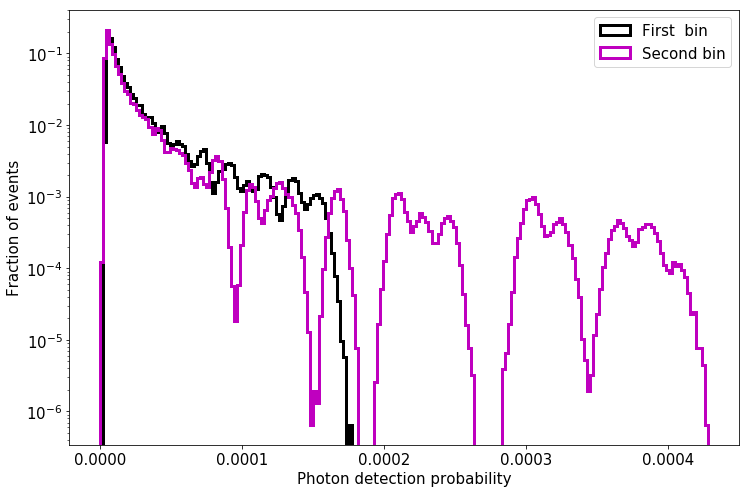

In [16]:
bins    = np.linspace(0, max(np.max(df_anode.P0), np.max(df_anode.P1)), 201)
weights = np.ones(len(df_anode)) / len(df_anode)

plt.hist(df_anode.P0, bins = bins, weights = weights, color="k", histtype="step", lw=3, label="First  bin")
plt.hist(df_anode.P1, bins = bins, weights = weights, color="m", histtype="step", lw=3, label="Second bin")

plt.legend()
plt.xlabel("Photon detection probability")
plt.ylabel("Fraction of events")
plt.yscale("log")

# PMT parametrization

In [17]:
def find_pitch(data):
    return np.min(np.diff(np.sort(np.unique(data))))

def find_nbins(data, d):
    return int(np.ceil((data.max() - data.min()) / d)) + 2

def find_binning(data):
    d = find_pitch(data)
    n = find_nbins(data, d)
    return np.linspace(df_cathode.X.min() - d/2,
                       df_cathode.X.max() + d/2,
                       n)

In [18]:
x_binning = find_binning(df_cathode.X)
y_binning = find_binning(df_cathode.Y)
r_binning = np.linspace(0, np.max(df_cathode.R  ) * 1.001, 201)
p_binning = np.linspace(0, np.max(df_cathode.Sum) * 1.001, 201)

/Applications/anaconda3/envs/IC3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6497: RuntimeWarning: invalid value encountered in greater
  h[h > cmax] = None


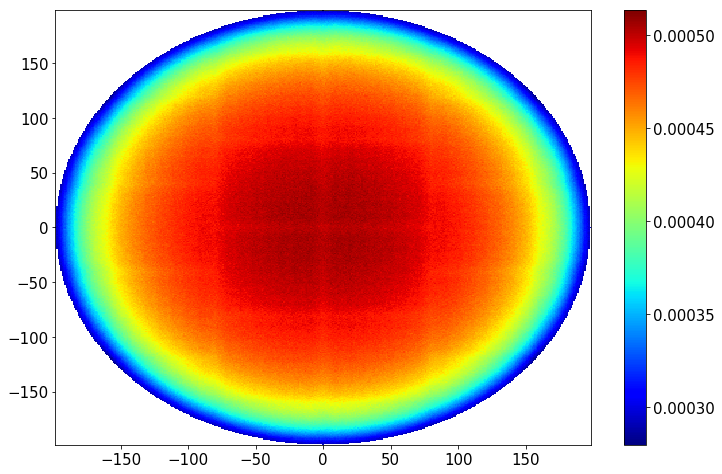

In [19]:
plt.hist2d(df_cathode.X, df_cathode.Y,
           (x_binning, y_binning),
           weights = df_cathode.Sum / 12,
           cmin    = df_cathode.Sum.min(),
           cmax    = df_cathode.Sum.max(),
           cmap    = "jet"
          )

plt.colorbar()

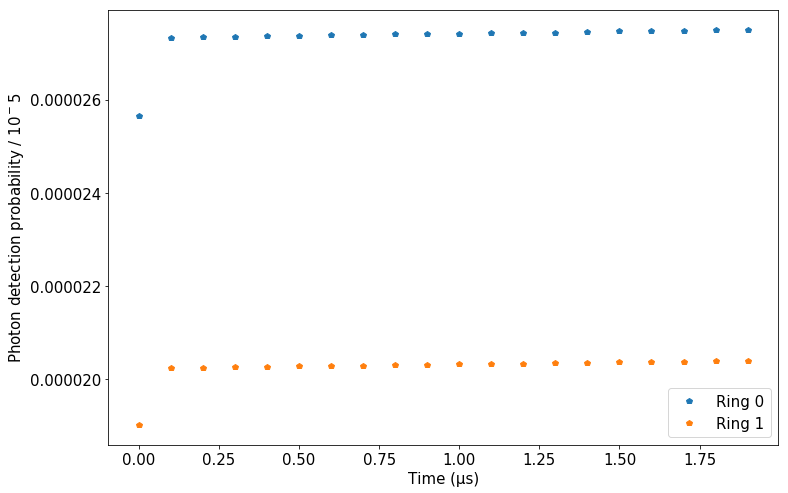

In [20]:
times = np.arange(0, 2, 0.1)
for ring, pmt in df_cathode.groupby("Ring"):
    ps = [pmt[f"P{t}"].mean() for t in range(len(times))]
    plt.plot(times, ps, "p", label=f"Ring {ring}")

plt.legend()
plt.xlabel("Time (µs)")
plt.ylabel("Photon detection probability / $10^-5$")

In [21]:
parametrizations = {}
profiles         = {}
pulls            = {}
for pmt_no, pmt in df_cathode.groupby("SensorID"):
    x, y, u = fitf.profileX(pmt.R, pmt.Sum, r_binning.size - 1, (r_binning[0], r_binning[-1]))
    ok = u > 0
    f  = fitf.fit(fitf.polynom, x[ok], y[ok], (-1, +1, -1, +1, -1, +1, pmt.Sum.max()), sigma=u[ok], maxfev=int(1e5))

    prediction = f.fn(pmt.R)
    pull       = (prediction - pmt.Sum) / (prediction * 1e-7)**0.5

    parametrizations[pmt_no] = f
    profiles        [pmt_no] = profile(x, y, u)
    pulls           [pmt_no] = pull

/Applications/anaconda3/envs/IC3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


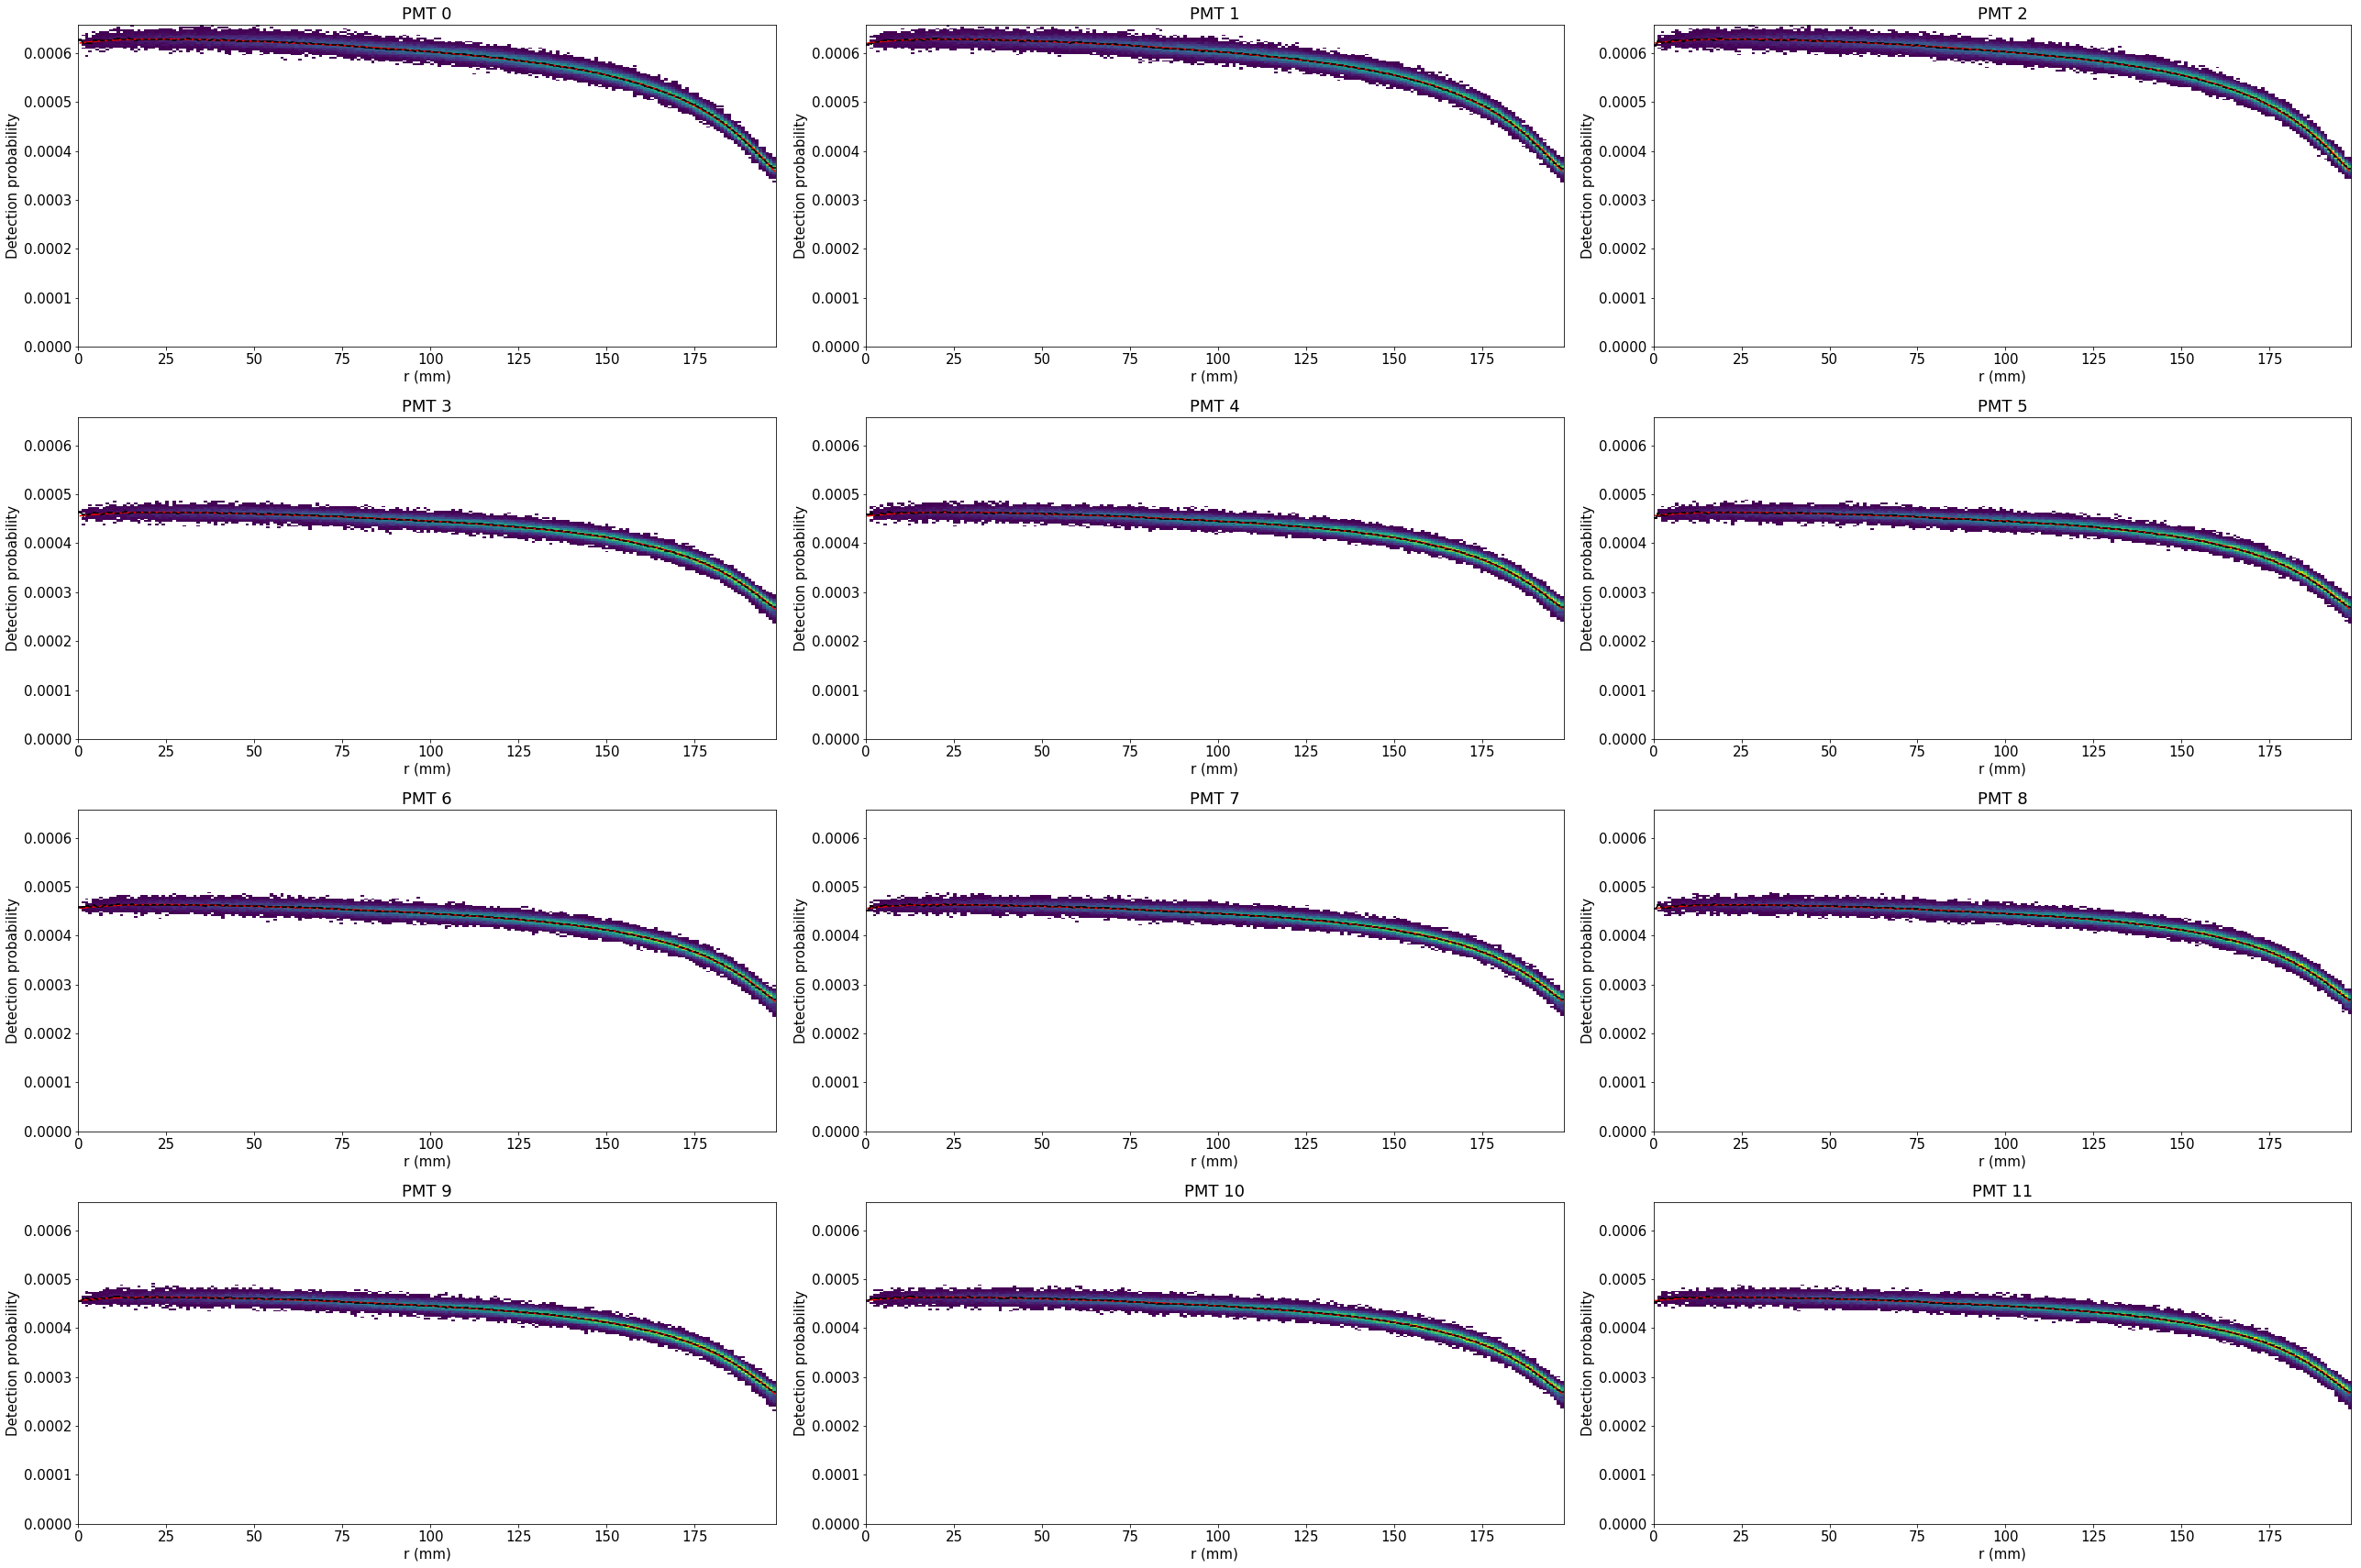

In [22]:
plt.figure(figsize=(36, 24))

for pmt_no, pmt in df_cathode.groupby("SensorID"):
    (x, y, u), f = profiles[pmt_no], parametrizations[pmt_no]

    plt.subplot(4, 3, pmt_no + 1)
    plt.hist2d(pmt.R, pmt.Sum, (r_binning, p_binning), cmin = 1e-8)
    plt.errorbar(x, y, u, np.diff(r_binning) / 2, "--k")
    plt.plot    (x, f.fn(x), "-r")
    plt.xlabel("r (mm)")
    plt.ylabel("Detection probability")
    plt.title (f"PMT {pmt_no}")
    plt.tight_layout()

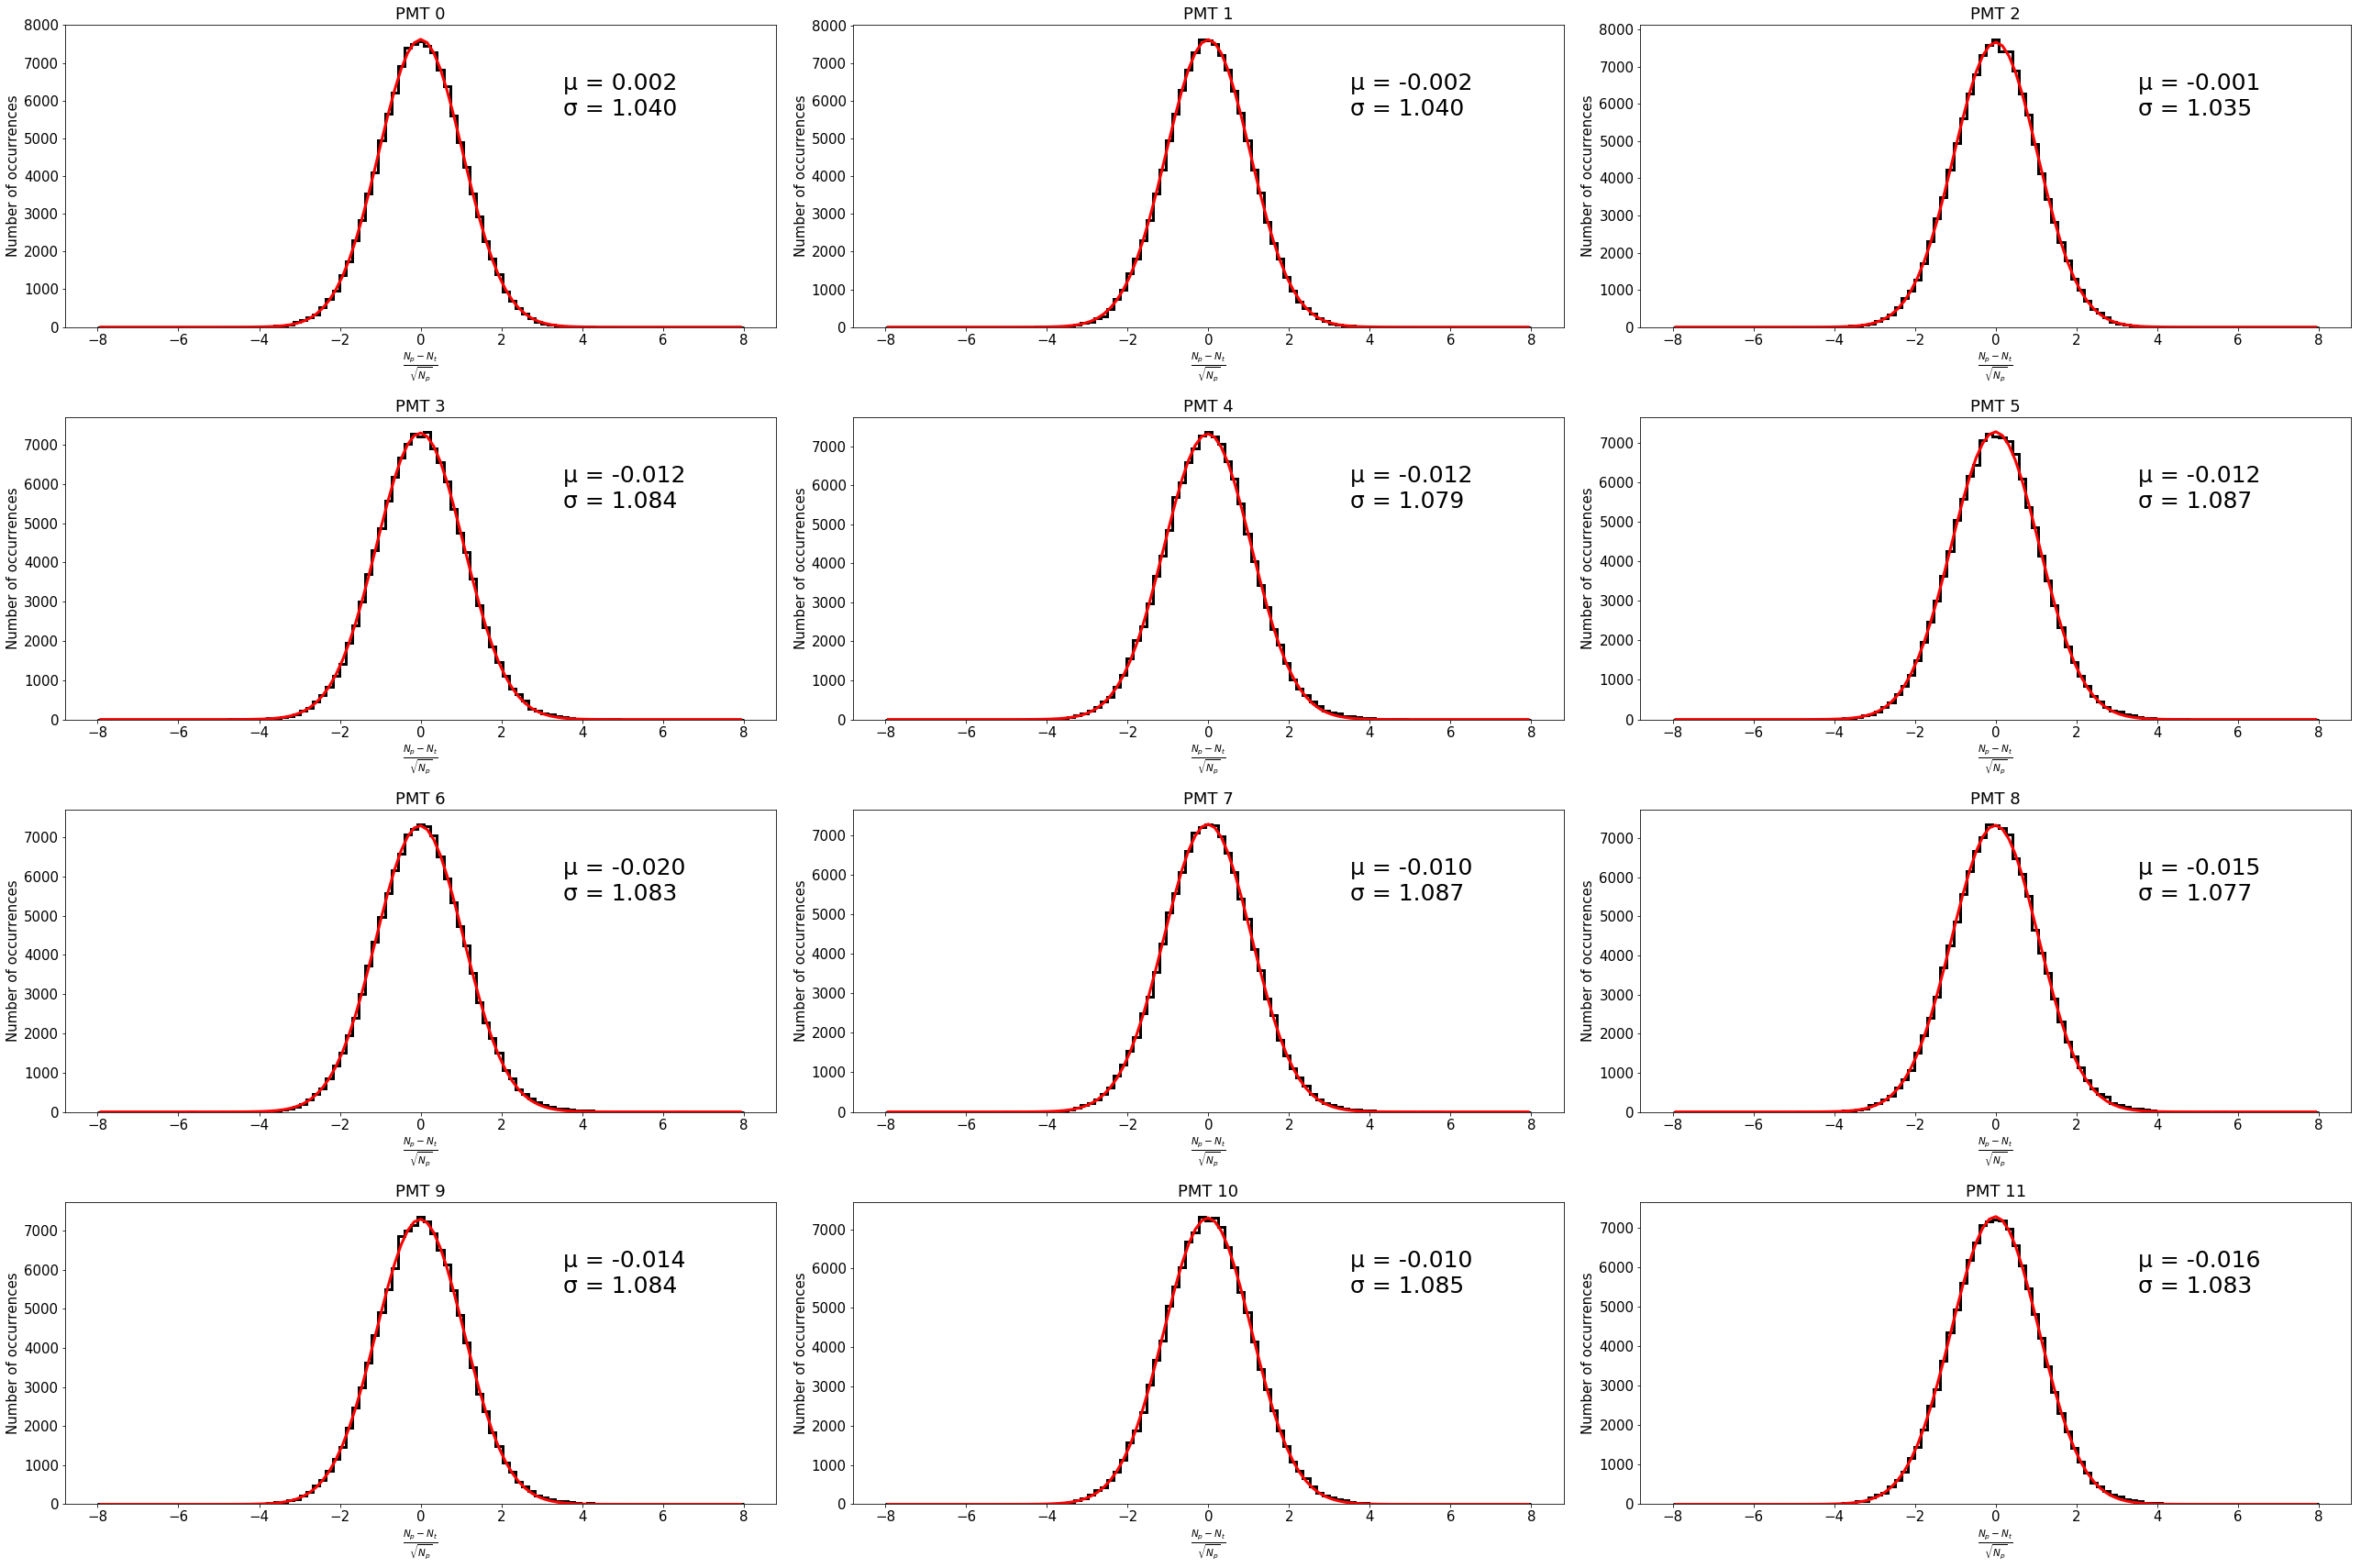

In [23]:
plt.figure(figsize=(36, 24))
pull_binning = np.linspace(-8, 8, 100)

for pmt_no, pmt in df_cathode.groupby("SensorID"):
    pull = pulls[pmt_no]
    y, x = np.histogram(pull, pull_binning)
    x    = x[:-1] + np.diff(x) / 2
    f    = fitf.fit(fitf.gauss, x, y, (1e4, 0, 1))

    plt.subplot(4, 3, pmt_no + 1)
    plt.hist   (pull, pull_binning, histtype="step", color="k", lw=3)
    plt.plot   (x, f.fn(x), "r-", lw=3)
    plt.text   (0.7, 0.7, f"µ = {f.values[1]:.3f}\nσ = {f.values[2]:.3f}", transform=plt.gca().transAxes, fontsize=25)
    plt.xlabel (r"$\frac{N_{p} - N_{t}}{\sqrt{N_{p}}}$")
    plt.ylabel ("Number of occurrences")
    plt.title  (f"PMT {pmt_no}")
plt.tight_layout()

# SiPM parametrization

In [24]:
dr_binning =  np.linspace(0, np.max(df_anode.dR) * 1.001, 501)
p_binning  = [np.linspace(0, np.max(df_anode.P0) * 1.001, 501),
              np.linspace(0, np.max(df_anode.P1) * 1.001, 501)]

In [25]:
parametrizations = {}
profiles         = {}
pulls            = {}
for bin_no in range(2):
    degree  = 11
    dr      = df_anode.dR
    data    = df_anode[f"P{bin_no}"]
    x, y, u = fitf.profileX(dr, data, dr_binning.size - 1, (dr_binning[0], dr_binning[-1]))
    ok      = (u > 0) & ~np.isnan(u) & np.isfinite(u)
    x, y, u = x[ok], y[ok], u[ok]
    seed    = (data.max(),) + tuple((-1)**i for i in range(1, degree + 1))
    f       = fitf.fit(fitf.polynom, x, y, seed, sigma=u, maxfev=int(1e5))

    prediction = f.fn(dr)
    pull       = (prediction - data) / (prediction * 1e-7)**0.5

    parametrizations[bin_no] = f
    profiles        [bin_no] = profile(x, y, u)
    pulls           [bin_no] = pull

/Users/Gonzalo/github/IC/invisible_cities/core/fit_functions.py:31: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(cov))


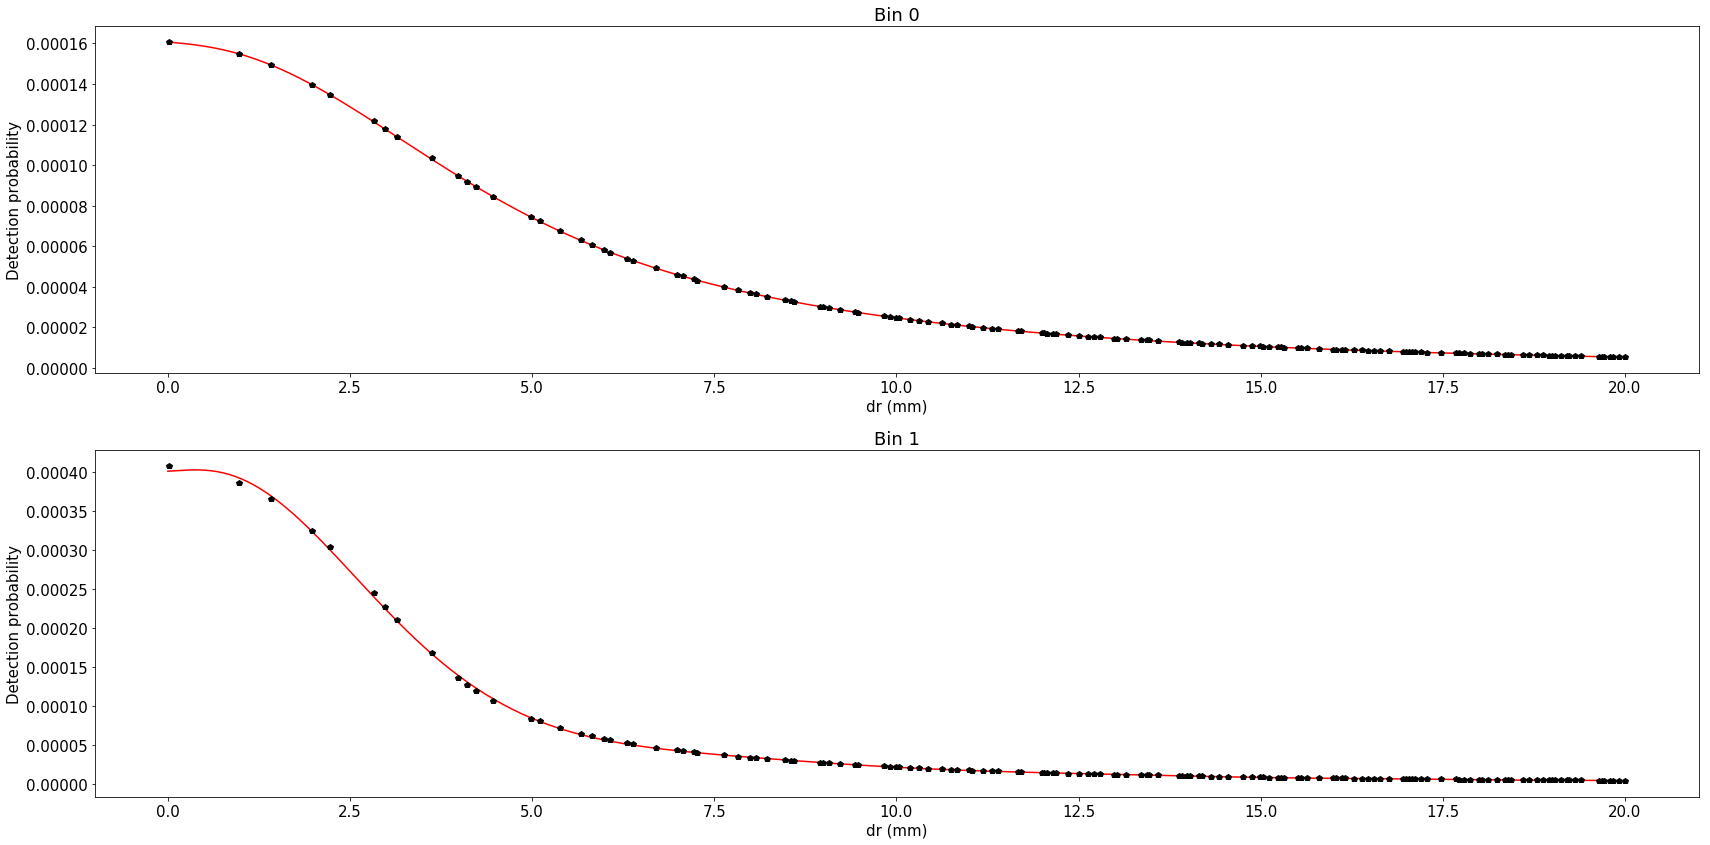

In [26]:
plt.figure(figsize=(24, 12))

for bin_no in range(2):
    (x, y, u), f = profiles[bin_no], parametrizations[bin_no]
    probs        = df_anode[f"P{bin_no}"]

    plt.subplot (2, 1, bin_no + 1)
#    plt.hist2d  (df_anode.dR, probs, (dr_binning, p_binning[bin_no]), cmin = 1e-8)
    plt.errorbar(x, y, u, np.diff(dr_binning)[0] / 2, "pk")
    plt.plot    (dr_binning, f.fn(dr_binning), "-r")
    plt.xlabel  ("dr (mm)")
    plt.ylabel  ("Detection probability")
    plt.title   (f"Bin {bin_no}")
plt.tight_layout()

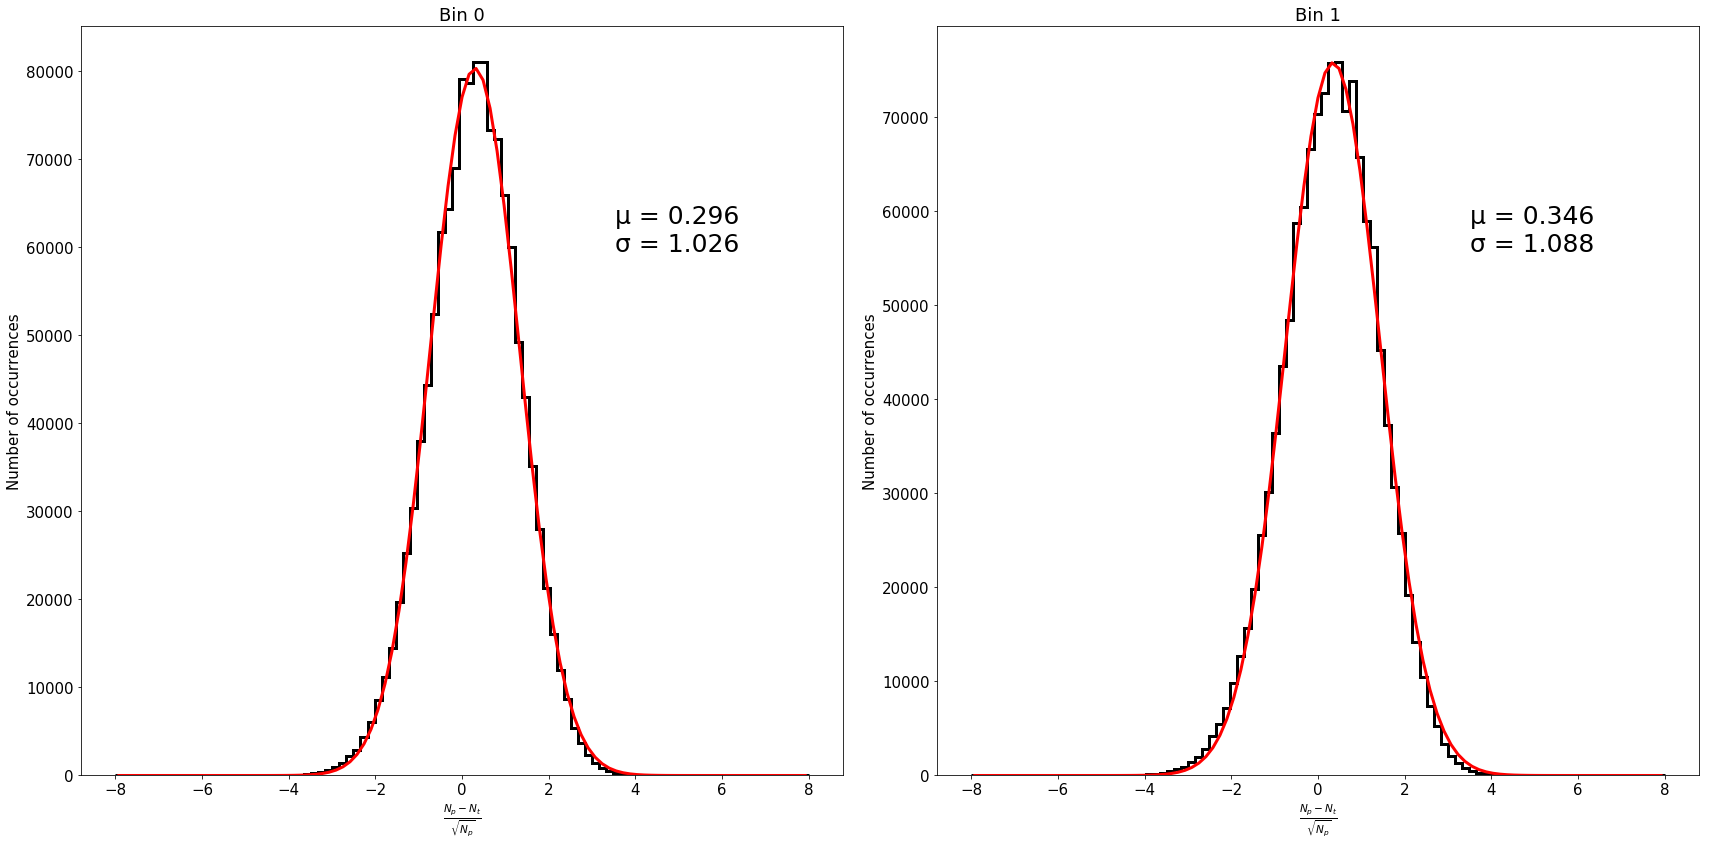

In [27]:
plt.figure(figsize=(24, 12))
pull_binning = np.linspace(-8, 8, 100)

for bin_no in range(2):
    sel  = (df_anode.R <= 180) & (df_anode.dR <= 20)
    pull = pulls[bin_no][sel]
    y, x = np.histogram(pull, pull_binning)
    x    = x[:-1] + np.diff(x) / 2
    f    = fitf.fit(fitf.gauss, x, y, (1, 0, 1))

    plt.subplot(1, 2, bin_no + 1)
    plt.hist   (pull, pull_binning, histtype="step", color="k", lw=3)
    plt.plot   (x, f.fn(x), "r-", lw=3)
    plt.text   (0.7, 0.7, f"µ = {f.values[1]:.3f}\nσ = {f.values[2]:.3f}", transform=plt.gca().transAxes, fontsize=25)
    plt.xlabel (r"$\frac{N_{p} - N_{t}}{\sqrt{N_{p}}}$")
    plt.ylabel ("Number of occurrences")
    plt.title  (f"Bin {bin_no}")
plt.tight_layout()